In [251]:
using Plots
using StatsPlots
using CSV
using DataFrames
using DataStructures

In [ ]:
pct_reductions = [0, 20, 40, 60, 80]
regions = ["MA", "CT", "ME"]
cement_types = ["Traditional_Cement_Plant", "EChem_Cement_Plant"]
elec_types = ["Battery", "ThermalPower{NaturalGas}", "Solar", "Wind"]

4-element Vector{String}:
 "Battery"
 "ThermalPower{NaturalGas}"
 "Solar"
 "Wind"

In [54]:
df = CSV.read("results/0pct_co2_reduction_capacity.csv", DataFrame)

Row,commodity,commodity_subtype,zone,resource_id,component_id,type,variable,value
,String15,String15,String15,String15,String31,String,String15,Float64
1,Cement,capacity,cement_produced,cement_MA,cement_MA_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,89.0278
2,Cement,capacity,cement_produced,cement_CT,cement_CT_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,89.5724
3,Cement,capacity,cement_produced,cement_ME,cement_ME_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,88.362
4,Cement,capacity,cement_produced,cement_MA,cement_MA_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,0.0
5,Cement,capacity,cement_produced,cement_CT,cement_CT_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,0.0
6,Cement,capacity,cement_produced,cement_ME,cement_ME_cement_edge,MacroEnergy.ElectrochemCementPlant{CementMaterials},capacity,0.0
7,Electricity,capacity,elec_MA_elec_CT,MA_to_CT,MA_to_CT_elec_edge,PowerLine,capacity,2954.07
8,Electricity,capacity,elec_MA_elec_ME,MA_to_ME,MA_to_ME_elec_edge,PowerLine,capacity,2000.0
9,Electricity,capacity,elec_MA,storage_MA,storage_MA_discharge_edge,Battery,capacity,3871.09


In [252]:
# Function for getting the capacity of certain technologies, split by region
function get_processed_capacity_df(capacity_df, types)
    # Add region column
    capacity_df.region = [resource_id[end-1:end] for resource_id in capacity_df.resource_id]

    # Rename tech types
    capacity_df.type[1:3] .= "Traditional_Cement_Plant"
    capacity_df.type[4:6] .= "EChem_Cement_Plant"
    capacity_df.type[15:16] .= "Solar"
    capacity_df.type[17:18] .= "Wind"

    # Filter out the types you want
    df_types = filter(row -> row.type in types, capacity_df)

    # Pivot table for readability
    df_pivot = unstack(df_types, :type, :region, :value)
    df_pivot = coalesce.(df_pivot, 0.0)

    return df_pivot
end

# Function for processing the flows of a specific commodity, split by region
function get_processed_flows_df(flows_df, commodity)
    # Add region column
    flows_df.region = [resource_id[end-1:end] for resource_id in flows_df.resource_id]

    # Filter out the types you want
    df_commodity = filter(row -> row.commodity == commodity, flows_df)

    # Pivot table for readability
    df_pivot = unstack(df_commodity, :type, :region, :value, combine=sum)
    df_pivot = coalesce.(df_pivot, 0.0)

    return df_pivot
end

# Function for getting a dictionary of dataframes for each scenario
function get_df_dict(dir, pct_list, metric, tech_types, commodity)
    # tech_types only needed for capacity_results_df (for filtering out which technology capacities you want to plot)
    # commodity only needed for flows_results_df (for summing over total flow of one commodity)
    df_dict = OrderedDict()
    for pct in pct_list
        filepath = "results/" * string(dir) * "/" * string(pct) * "pct_co2_reduction_" * metric * ".csv"
        df = CSV.read(filepath, DataFrame)
        if metric == "capacity"
            df_types = get_processed_capacity_df(df, tech_types)
        elseif metric == "flows"
            df_types = get_processed_flows_df(df, commodity)
        end
        df_dict[pct] = df_types
    end
    return df_dict
end

function get_matrix(df)
    matrix = Matrix(df[:, regions])'
    return matrix
end

get_matrix (generic function with 1 method)

In [253]:
function plot_df_dict(df_dict, legend_labels, ylabel, ylim)
    n = length(df_dict)

    # 1. Define 3x2 grid layout
    plot_layout = @layout [a b c; d e f]
    
    # 2. Create the big plot with the layout
    p = plot(layout = plot_layout, size = (800, 500))  # Adjust width/height as needed
    
    values = nothing
    # 3. Loop over each scenario
    for (i, (pct, df)) in enumerate(df_dict)
        values = get_matrix(df)

        if legend_labels == nothing
            legend_labels = df.type
        end
    
        # Plot in correct subplot
        groupedbar!(
            regions,
            values,
            bar_position = :stack,
            bar_width = 0.7,
            xlabel = "Regions",
            ylabel = ylabel,
            title = "$(pct)% CO₂ Reduction",
            ylim = ylim,
            subplot = i,
            legend = false # Only show legend in last plot
        )
    end
    
    # 4. Add empty plot in subplot 6 with only legend
    groupedbar!(
        zeros(size(values)),    # Empty y data but correct shape
        label = permutedims(legend_labels), # Labels only for legend
        subplot = 6,
        legend = :left,
        framestyle = :none,              # Remove axes/frames
    )
    
    display(p)

end

plot_df_dict (generic function with 1 method)

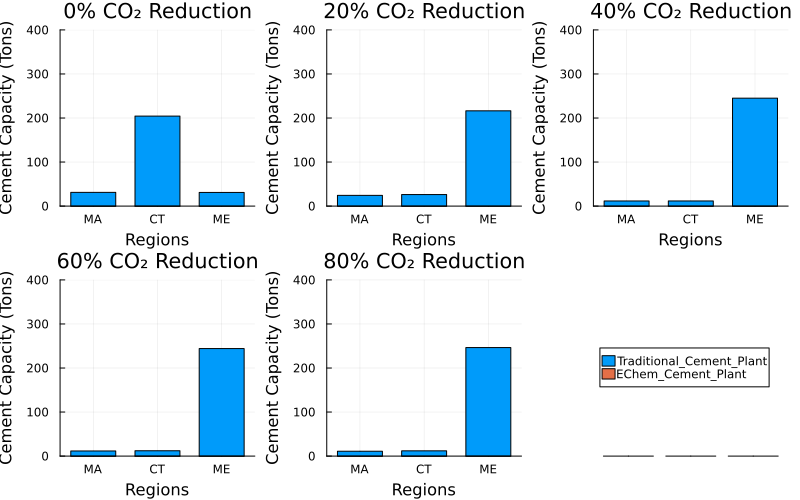

In [254]:
cement_capacity = get_df_dict("base_case", pct_reductions, "capacity", cement_types, "")
plot_df_dict(cement_capacity, cement_types, "Cement Capacity (Tons)", (0, 400))

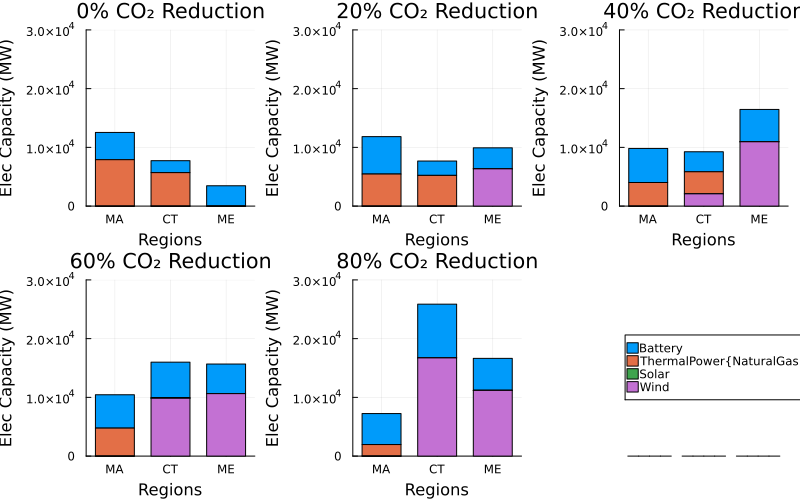

In [255]:
elec_capacity = get_df_dict("base_case", pct_reductions, "capacity", elec_types, "")
plot_df_dict(elec_capacity, elec_types, "Elec Capacity (MW)", (0, 3e4))

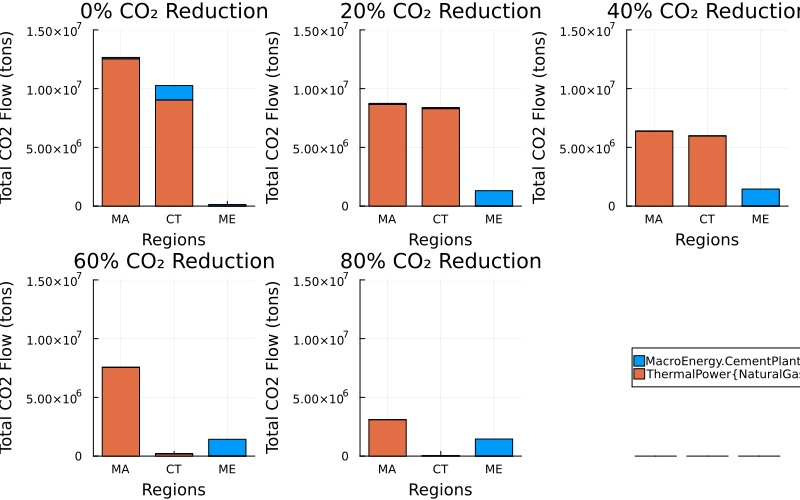

In [256]:
commodity = "CO2"
total_flow = get_df_dict("base_case", pct_reductions, "flows", "", commodity)
plot_df_dict(total_flow, nothing, "Total CO2 Flow (tons)", (0, 1.5e7))